In [71]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [72]:
#btc options data
df=pd.read_csv('data/btc_data.csv', sep=",", index_col=0)
#df.drop(columns=['Unnamed: 0', 'interest_rate'], inplace=True)

In [73]:
from datetime import datetime

today = datetime.today()
df['Time to Expiration'] = df['Expiration Date'].apply(lambda x: (datetime.strptime(x, '%d%b%y') - today).days / 365)
btc_data = df   

_---test ---

In [74]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Define the spot price and percentage limits
spot_price = df['underlying_price'].mean()  # Assuming a spot price column exists

# Extract relevant data for the surface plot
strikes = df['Strike Price'].values
times_to_expiration = df['Time to Expiration'].values
implied_vols = df['mark_iv'].values

# Create meshgrid for strikes and times_to_expiration
X, Y = np.meshgrid(np.unique(strikes), np.unique(times_to_expiration))

# Interpolate the implied volatilities to fill the grid
Z = griddata((strikes, times_to_expiration), implied_vols, (X, Y), method='linear')

# Create the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

fig.update_layout(title='Interactive Implied Volatility Surface', autosize=False,
                  width=700, height=700,
                  scene=dict(
                      xaxis_title='Strike Price',
                      yaxis_title='Time to Expiry',
                      zaxis_title='Recalculated Implied Volatility'))
fig.show()


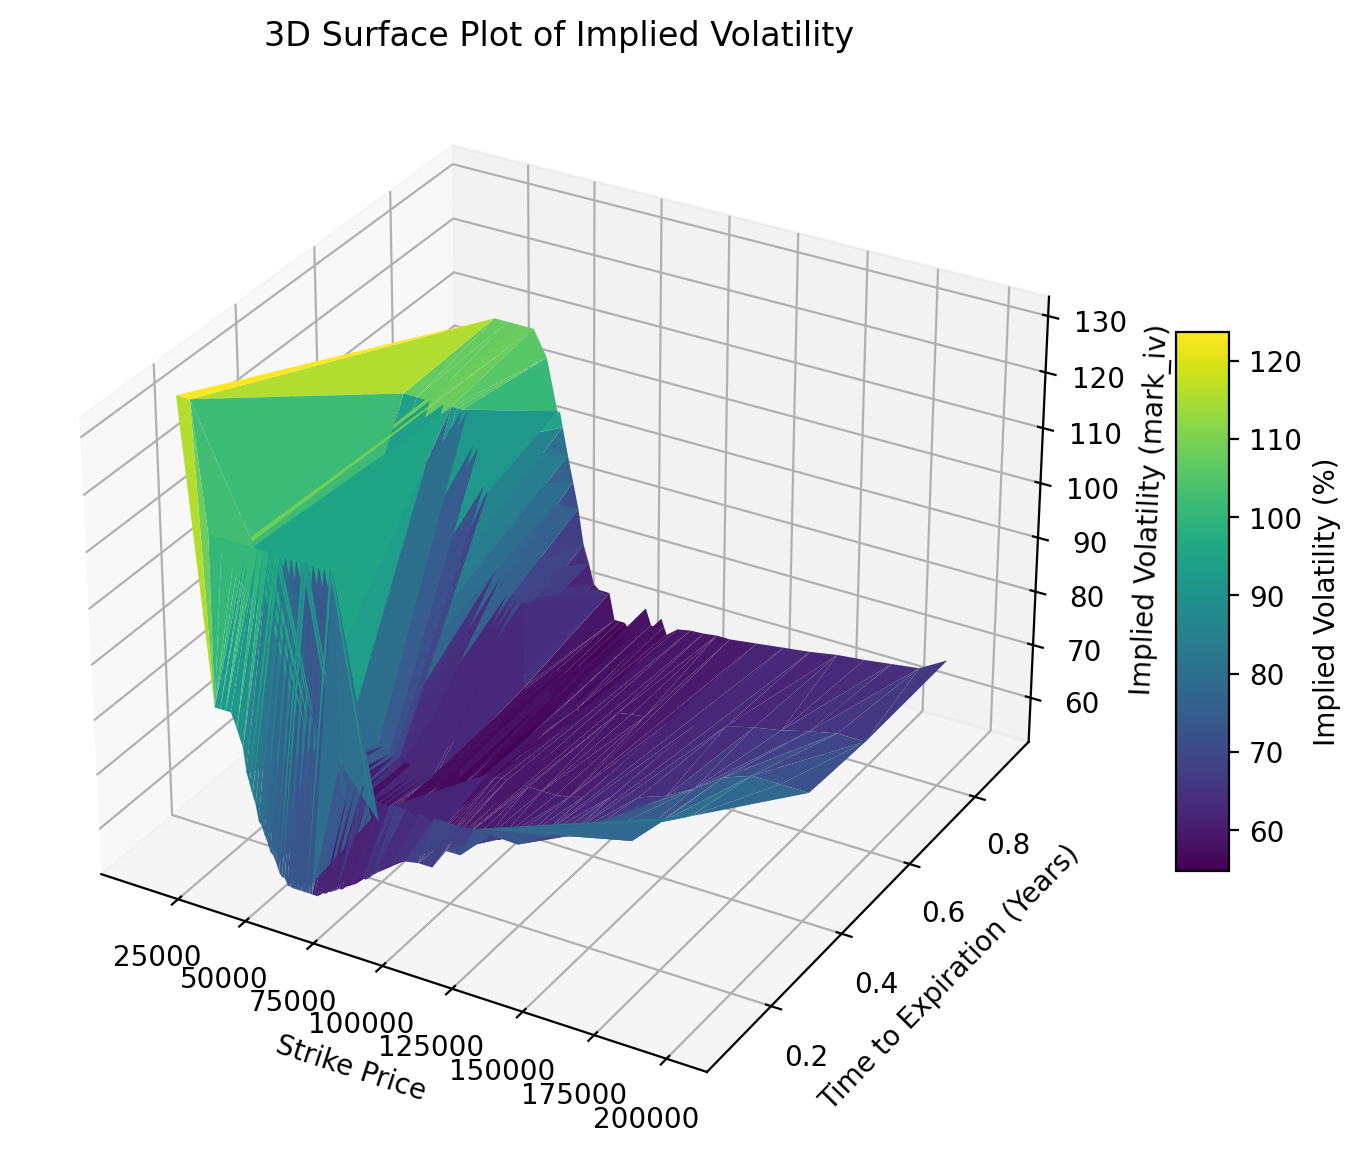

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime

# Convert 'Expiration Date' to datetime for calculating time to expiration
btc_data['Expiration Date'] = pd.to_datetime(btc_data['Expiration Date'], format='%d%b%y')
current_date = datetime.now()
btc_data['Time to Expiration'] = (btc_data['Expiration Date'] - current_date).dt.days / 365  # in years

# Filter data to have non-zero 'mark_iv' values for plotting
btc_data_filtered = btc_data[btc_data['mark_iv'] > 0]

# Prepare data for 3D surface plot
X = btc_data_filtered['Strike Price'].values
Y = btc_data_filtered['Time to Expiration'].values
Z = btc_data_filtered['mark_iv'].values

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_trisurf(X, Y, Z, cmap=cm.viridis, edgecolor='none')

# Add labels and color bar
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Expiration (Years)')
ax.set_zlabel('Implied Volatility (mark_iv)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Implied Volatility (%)')

plt.title('3D Surface Plot of Implied Volatility')
plt.show()


In [ ]:
_---test ---

Calc. IV (Bisection-Newton-Raphson hybrid) 

In [61]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

# Black-Scholes formula to calculate the option price for a given volatility
def black_scholes_call_price(S, K, T, r, sigma):
    """Calculate the Black-Scholes call price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Calculate the implied volatility using the Bisection-Newton-Raphson hybrid method
def implied_volatility_hybrid(price, S, K, T, r, tolerance=1e-5, max_iterations=100):
    """Calculate implied volatility using Bisection-Newton-Raphson hybrid method."""
    # Initial bounds for volatility
    lower_bound = 1e-5
    upper_bound = 5.0

    def objective_function(vol):
        return black_scholes_call_price(S, K, T, r, vol) - price

    # Use Brent's method for initial robust solution (combines Bisection and more advanced methods)
    try:
        implied_vol = brentq(objective_function, lower_bound, upper_bound, xtol=tolerance)
    except ValueError:
        implied_vol = np.nan  # In case the solution is not found

    return implied_vol
 

In [62]:
# turning "mark_iv" to be from 0 to 1 
if btc_data['mark_iv'].max() != btc_data['mark_iv'].min():  # Ensure range is not zero
    btc_data['mark_iv_normalized'] = (btc_data['mark_iv'] - btc_data['mark_iv'].min()) / (btc_data['mark_iv'].max() - btc_data['mark_iv'].min())
else:
    btc_data['mark_iv_normalized'] = 0  # Set all to 0 if there's no variation


In [63]:
# Re-apply the implied volatility calculation with filtering for non-zero prices and using `mark_iv` as a fallback

# Filter out rows where best_bid_price and best_ask_price are zero
btc_data_filtered = btc_data[(btc_data['best_bid_price'] > 0) | (btc_data['best_ask_price'] > 0)]

# Re-calculate implied volatility for filtered data using best_ask_price if best_bid_price is too low
btc_data_filtered['Implied_Volatility'] = btc_data_filtered.apply(
    lambda row: implied_volatility_hybrid(
        price=row['best_ask_price'] if row['best_bid_price'] == 0 else row['best_bid_price'],
        S=row['underlying_price'],
        K=row['Strike Price'],
        T=(pd.to_datetime("2024-11-29") - pd.to_datetime("2023-10-28")).days / 365,  # Time to expiration in years
        r=row['interest_rate']
    ) if row['best_bid_price'] > 0 or row['best_ask_price'] > 0 else row['mark_iv'],  # Use mark_iv as fallback
    axis=1
)


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_18060\3626007541.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Interactive Implied Volatility Surface

In [64]:
btc_options_filtered = btc_data_filtered

In [65]:
btc_options_filtered[['Strike Price','Time to Expiration','Implied_Volatility']]


,Strike Price,Time to Expiration,Implied_Volatility
best_bid_amount,,,
0.0,40000,0.084932,NaN
0.1,47000,0.084932,NaN
9.9,40000,0.084932,NaN
31.9,46000,0.084932,NaN
16.2,45000,0.084932,NaN
...,...,...,...
8.5,140000,0.909589,0.174332
1.7,160000,0.909589,0.173572
7.2,160000,0.909589,0.210330


In [66]:
len(btc_options_filtered)

386

In [67]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Define the spot price and percentage limits
spot_price = btc_options_filtered['underlying_price'].mean()  # Assuming a spot price column exists


# Extract relevant data for the surface plot
strikes = btc_options_filtered['Strike Price'].values
times_to_expiration = btc_options_filtered['Time to Expiration'].values
implied_vols = btc_options_filtered['Implied_Volatility'].values

# Create meshgrid for strikes and times_to_expiration
X, Y = np.meshgrid(np.unique(strikes), np.unique(times_to_expiration))

# Interpolate the implied volatilities to fill the grid
Z = griddata((strikes, times_to_expiration), implied_vols, (X, Y), method='linear')

# Create the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

fig.update_layout(title='Interactive Implied Volatility Surface', autosize=False,
                  width=700, height=700,
                  scene=dict(
                      xaxis_title='Strike Price',
                      yaxis_title='Time to Expiry',
                      zaxis_title='Recalculated Implied Volatility'))
fig.show()


In [68]:
len(btc_options_filtered)

386

In [70]:


implied_vols = btc_options_filtered['mark_iv_normalized'].values

# Create meshgrid for strikes and times_to_expiration
X, Y = np.meshgrid(np.unique(strikes), np.unique(times_to_expiration))

# Interpolate the implied volatilities to fill the grid
Z = griddata((strikes, times_to_expiration), implied_vols, (X, Y), method='linear')

# Create the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

fig.update_layout(title='Interactive Implied Volatility Surface', autosize=False,
                  width=700, height=700,
                  scene=dict(
                      xaxis_title='Strike Price',
                      yaxis_title='Time to Expiry',
                      zaxis_title='Recalculated Implied Volatility'))
fig.show()
